# Imports

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request

# Fetch Data

In [4]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()  

In [5]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [6]:
train = load_titanic_data('train.csv')
test = load_titanic_data('test.csv')

# Data Exploration

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [10]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
for col in ['Survived', 'Pclass','Sex', 'Embarked']:
    print (train[col].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


# Prepared Data for ML

In [16]:
train.duplicated().sum()

0

In [17]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [25]:
num_columns = ['Age', 'SibSp', 'Parch', 'Fare']
cat_columns = ['Pclass', 'Sex', 'Embarked']

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

onehot = OneHotEncoder()
onehot.fit_transform(train[cat_columns])

<891x9 sparse matrix of type '<class 'numpy.float64'>'
	with 2673 stored elements in Compressed Sparse Row format>

In [27]:
num_columns + cat_columns

['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Embarked']

In [50]:
onehot.categories_

[array([1, 2, 3], dtype=int64),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S', nan], dtype=object)]

In [40]:
X_train = train[num_columns + cat_columns]
y_train = train['Survived'].values


In [41]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', cat_pipeline, cat_columns)
])

In [59]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [60]:
X_train_prepared.shape

(891, 12)

# Start Modeling

## Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(random_state=42)

In [57]:
X_test_prepared = full_pipeline.transform(test)

In [61]:
y_pred = forest_clf.predict(X_test_prepared)

In [73]:
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest_clf, X_train_prepared, y_train, cv=10)


In [64]:
forest_scores.mean()

0.8137578027465668

## SVC

In [66]:
from sklearn.svm import SVC

In [80]:
svc_clf = SVC(gamma='auto')
svc_scores = cross_val_score(svc_clf, X_train_prepared, y_train, cv=10)
svc_scores.mean()

0.8249313358302123

{'whiskers': [<matplotlib.lines.Line2D at 0x18dc0f95ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x18dc0f97350>,
 'boxes': [<matplotlib.lines.Line2D at 0x18dc0f95710>,
 'medians': [<matplotlib.lines.Line2D at 0x18dc0f9c490>,
 'fliers': [<matplotlib.lines.Line2D at 0x18dc0f97250>,
 'means': []}

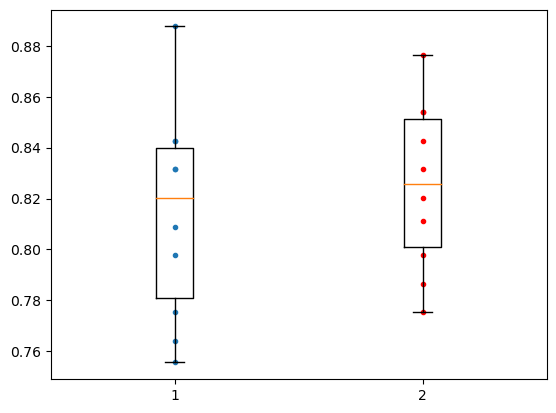

In [78]:
plt.plot([1]*10, forest_scores, '.')
plt.plot([2]*10, svc_scores, 'r.')
plt.boxplot([forest_scores, svc_scores] )

## KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(algorithm='auto')
knn_scores = cross_val_score(knn_clf, X_train_prepared, y_train, cv=10)
knn_scores.mean()

0.8058676654182273

## SGD

In [88]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(tol=1e-3,max_iter=1000, )
sgd_scores = cross_val_score(sgd_clf, X_train_prepared, y_train, cv=10)
sgd_scores.mean()

0.7519725343320849

## Multiple Models

In [89]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
]
knn_clf.__class__

In [95]:
my_dict = {}
for classifier in classifiers:
    scores = cross_val_score(classifier, X_train_prepared, y_train, cv=10)
    mean = scores.mean()
    my_dict[classifier.__class__] = scores
    print(classifier.__class__, mean)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 0.7969413233458178
<class 'sklearn.svm._classes.SVC'> 0.786729088639201
<class 'sklearn.svm._classes.SVC'> 0.803645443196005
<class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'> 0.823832709113608
<class 'sklearn.tree._classes.DecisionTreeClassifier'> 0.8058926342072409
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 0.8036204744069912
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 0.7857428214731585
<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 0.8013483146067417
<class 'sklearn.naive_bayes.GaussianNB'> 0.7856803995006241
